In [1]:
%%capture
!pip install gymnasium
!pip install gymnasium[classic-control]

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import os
import datetime


import import_ipynb
from truly_plastic_p4 import plastic_nn
from truly_plastic_p4 import input_layer
from truly_plastic_p4 import layer

importing Jupyter notebook from truly_plastic_p4.ipynb


In [367]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [368]:

class replay_memory():
    def __init__(s, maxlen):
        s.memory = deque([], maxlen=maxlen)

    def append(s, transition):
        s.memory.append(transition)

    def sample(s, sample_size):
        return random.sample(s.memory, sample_size)

    def __len__(s):
        return len(s.memory)



class DQN():
   
    def __init__(s, ct = 0, tag=0, path = r'test', 
                 game_name = 'MountainCar-v0', 
                  
                 mini_batch_size = 32,  num_divisions = 1, 
                 replay_memory_size = 100000, 
                 network_sync_rate = 50000, discount_factor_g = 0.9):
        
        if (ct == 0):
            ct = datetime.datetime.now()
            ct = str(ct)
            ct = ct.replace(":", "-")
            ct = ct.replace(" ", "_")
            ct = ct[:-7]

        s.ct = ct
        current_directory = os.getcwd()
        final_directory_pics = os.path.join(current_directory, s.ct)
        
        final_directory_pics = os.path.join(final_directory_pics, 'pics')
        if not os.path.exists(final_directory_pics):
            os.makedirs(final_directory_pics)
        
        if (tag != 0):
            s.set_tag(tag)

        s.game_name = game_name
        s.discount_factor_g = discount_factor_g
         
        s.mini_batch_size = mini_batch_size 
        s.num_divisions = num_divisions

        # Divide position and velocity into segments
        s.lin_spaces = []
        env = gym.make(s.game_name)
        obs_space = env.observation_space

        for i in range(obs_space.shape[0]):
            s.lin_spaces.append(np.linspace(env.observation_space.low[i], env.observation_space.high[i], s.num_divisions))

        env.close()

        
        s.is_desrcete = False if num_divisions == 1 else False
        
        s.replay_memory_size =  replay_memory_size 
        s.network_sync_rate = network_sync_rate
        
    def set_tag(s, tag):
        s.tag = tag
        s.path = s.ct+'/'+s.tag
        current_directory = os.getcwd()
        final_directory = os.path.join(current_directory, s.path)
        if not os.path.exists(final_directory):
            os.makedirs(final_directory)
        
   
    def plot_progress(self, rewards_per_episode_, epsilon_history_):
        
        plt.figure()
        
        plt.xlabel('epochs')
        plt.ylabel('reward')
        plt.plot(rewards_per_episode_)

        plt.savefig(f'{self.path}/info_rew_{self.tag}.png'.format(self.path, self.tag))
        plt.savefig(f'{self.ct}/pics/info_rew_{self.tag}.png')
        plt.close()

        plt.figure()
        
        plt.xlabel('epochs')
        plt.ylabel('epsilon')
        plt.plot(epsilon_history_)
        plt.savefig(f'{self.path}/info_eps_{self.tag}.png'.format(self.path, self.tag))
        plt.close()

    
    def save_info(s, info):
        file_path = f'{s.path}/info_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a")   
       
        f.write("data {}\n".format(s.ct))
        f.write("tag {}\n".format(s.tag))
        f.write("game_name {}\n".format(s.game_name))
        f.write("reward discount factor {}\n".format(s.discount_factor_g))
        f.write("minibatch size {}\n".format(s.mini_batch_size))
        f.write("num divisions{}\n".format(s.num_divisions))
        f.write("replay memory size {}\n".format(s.replay_memory_size))
        f.write("network sync rate {}\n".format(s.network_sync_rate))
        f.write("info {}\n".format(info))
                         
        f.close()
    
    def add_log_data(s, data):
        file_path = f'{s.path}/info_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()
        
    def save_reward_data(s, data):
        file_path = f'{s.path}/rewards_{s.tag}.txt'.format(s.path, s.tag)
        f = open(file_path, "a") 
        f.write("{}\n".format(data))
                         
        f.close()



    
    def run_one_epoch(s, i):
        s.state = s.env.reset()[0] # seed = int(s.tag) + i
        s.terminated = False
        s.truncated = False
        s.rewards = 0

        while(not s.terminated and s.rewards < 300):# and s.rewards > -1000
            if random.random() < s.epsilon:
                s.action = s.env.action_space.sample()
            else:
                s.res = s.policy_dqn.forward(s.state_to_dqn_input(s.state))
                s.action = s.res.argmax().item()

            s.new_state, s.reward, s.terminated, s.truncated, _ = s.env.step(s.action)
            s.rewards += s.reward
            s.memory.append((s.state, s.action, s.new_state, s.reward, s.terminated))
            s.state = s.new_state
            
            s.step_count+=1
 
        
        if(s.terminated):
            s.goal_reached = True

        s.rewards_per_episode.append(s.rewards)
        
        
        if(i!=0 and i%1000==0): # Graph training progress
            print(f'Episode {i} Epsilon {s.epsilon}')
            
            s.policy_dqn.save(f'{s.path}/mc_policy_{i}'.format(s.path, i))
            s.add_log_data(f'Episode {i} Epsilon {s.epsilon}')
            
            s.plot_progress(s.rewards_per_episode, s.epsilon_history)

        
        if s.rewards > s.best_rewards:
            s.best_rewards = s.rewards
            
            print(f'Best rewards so far: {s.best_rewards}')
            s.add_log_data(f'Best rewards so far: {s.best_rewards}')
            s.policy_dqn.save(f'{s.path}/mc_policy_{i}'.format(s.path, i))
            s.policy_dqn.save(f'{s.path}/mc_policy_best'.format(s.path))
            

        if len(s.memory) > s.mini_batch_size and s.goal_reached: # if enough experience has been collected

            s.mini_batch = s.memory.sample(s.mini_batch_size)
            s.optimize(s.mini_batch)#, s.policy_dqn, s.target_dqn)

            # Decay epsilon
            s.epsilon = max(s.epsilon - 1/s.episodes, 0.01) 
            s.epsilon_history.append(s.epsilon)

            # Copy policy network to target network after a certain number of steps
            if s.step_count > s.network_sync_rate:
                s.target_dqn = s.policy_dqn.deep_copy()
                s.step_count = 0

        return s.rewards
    


    
    def init_train_data(s, policy_dqn, episodes):
        s.policy_dqn = policy_dqn
        s.target_dqn = plastic_nn()
        s.target_dqn = policy_dqn.deep_copy()

        
        s.epsilon = 1 # 1 = 100% random actions
        s.memory = replay_memory(s.replay_memory_size)

        s.rewards_per_episode = []
        s.epsilon_history = []

        # Track number of steps taken. Used for syncing policy => target network.
        s.step_count = 0
        s.goal_reached = False
        s.best_rewards = -200 #-1000

        s.episodes = episodes 
        s.env = gym.make(s.game_name)

    
    def train(s, episodes):
        #s.init_train_data(policy_dqn, episodes)
        

        # main training
        for i in range(s.episodes+1):
            s.run_one_epoch(i)
        
        # # done
        # s.post_train()


    def post_train(s):
                
        s.env.close()
        s.policy_dqn.save(f'{s.path}/mc_policy_last_{s.tag}'.format(s.path, s.tag))
        
        if (s.best_rewards == -200): #update best -1000
            s.policy_dqn.save(f'{s.path}/mc_policy_best'.format(s.path))
            
        s.save_reward_data(s.rewards_per_episode)


    
    def optimize(s, mini_batch):
        s.target_q_list = []
        s.input_list = []
        
        for state, action, new_state, reward, terminated in mini_batch:
            if terminated:
                s.target = reward
            else:
                s.target = reward + s.discount_factor_g * s.target_dqn.forward(s.state_to_dqn_input(new_state)).max()

            # Get the target set of Q values
            s.state_dsc = np.asarray(s.state_to_dqn_input(state))
            s.input_list.append(s.state_dsc)
            
            s.target_q = s.target_dqn.forward(s.state_dsc)
            
            # Adjust the specific action to the target that was just calculated
            s.target_q[action] = s.target            
            s.target_q_list.append(s.target_q)

        #BACKPOP AND UPDATE on minibatch
        x = np.asarray(s.input_list)
        x = x[:, :, 0]
        x = x.T

        y = np.asarray(s.target_q_list)
        y = y[:, :, 0]
        y = y.T

        s.policy_dqn.learn_one(x, y)



    def state_to_dqn_input(s, state):
        
        if (not s.is_desrcete):
            return np.asarray([state]).T
        else:
            d_state = []
            for i in range(state.shape[0]):
                dig = np.digitize(state[i], s.lin_spaces[i])
                d_state.append(np.asarray([dig]))
        
            return np.asarray(d_state)


        

    def test(self, policy_dqn, episodes, render = False):
        env = gym.make(self.game_name, render_mode='human' if render else None)
        
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n

        done_count = 0
        medium_reward = 0
        reward_list = []
        
        for i in range(episodes):
            state, info = env.reset() 
            done = False
            truncated = False 
            rewards = 0

            while(not done and not truncated):
                state = self.state_to_dqn_input(state)

                res = policy_dqn.forward(state)

                action = res.argmax().item()

                state, reward, done, truncated, _ = env.step(action)
                rewards+=reward
                if (truncated):
                    done_count += 1
                    break

            medium_reward += rewards
            reward_list.append(rewards)
                

        
        env.close()
        medium_reward = medium_reward / episodes
        return done_count*100.0/episodes, medium_reward, reward_list
        



## alg

In [4]:
import time

0
1
2
3
4
0
1
2
3
4
Episode 1000 Epsilon 1
Best rewards so far: -912.0
Episode 2000 Epsilon 0.691000000000034
Episode 1000 Epsilon 1
Episode 2000 Epsilon 1
Episode 1000 Epsilon 1
Best rewards so far: -773.0
Episode 2000 Epsilon 0.7260000000000302
Episode 1000 Epsilon 1
Best rewards so far: -577.0
Episode 2000 Epsilon 0.9230000000000085
Episode 1000 Epsilon 1
Best rewards so far: -779.0
Episode 2000 Epsilon 0.6595000000000375
0
1
2
3
4


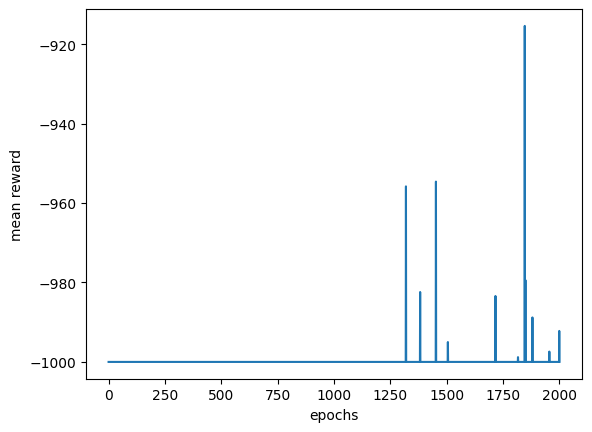

In [9]:
# learning_rate_a = 0.001
# game_name = "MountainCar-v0"
# env = gym.make(game_name)
# in_states = env.observation_space.shape[0]
# out_actions = env.action_space.n
# env.close()


# h1_nodes = 3
# h2_nodes = 2

# a_type1 = 'ReLU'
# a_type2 = 'Linear'


# num_of_nn = 5


# dqn_s = []


# ct = datetime.datetime.now()
# ct = str(ct)
# ct = ct.replace(":", "-")
# ct = ct.replace(" ", "_")
# ct = ct[:-7]

# for i in range(num_of_nn):
#     print(i)
#     layers_net = [input_layer(in_states), 
#     layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_type1), 
#     layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_type1), 
#     layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_type2)]
    
#     policy_dqn = plastic_nn(optimizer="Adam")
#     policy_dqn.append_layers(layers_net)
    
#     dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 50)
#     dqn_test.set_tag(str(i))
    
#     dqn_s.append(dqn_test)
#     #time.sleep(60)
    
# episodes = 2000

# for i in range (num_of_nn):
#     print(i)
#     dqn_s[i].init_train_data(policy_dqn, episodes)

# #mean_results = []
# summs = np.zeros(shape = episodes+1)
# for i in range (num_of_nn):
#     summ = 0
#     for e in range(episodes + 1):
#         summs[e] += dqn_s[i].run_one_epoch(e)
#     #mean_results.append(summ/num_of_nn)
#     #print(res)
        
# for i in range (num_of_nn):
#     print(i)
#     dqn_s[i].post_train()

# mean_results = summs / num_of_nn
# plt.figure()

# plt.xlabel('epochs')
# plt.ylabel('mean reward')
# plt.plot(mean_results)
# plt.show()
# plt.close()


1
Best rewards so far: 13.0
0  success percent   0.0  mean reward  9.28
Best rewards so far: 17.0
1  success percent   0.0  mean reward  9.51
Best rewards so far: 18.0
2  success percent   0.0  mean reward  10.02
Best rewards so far: 31.0
3  success percent   0.0  mean reward  9.3
Best rewards so far: 23.0
4  success percent   0.0  mean reward  9.37
Best rewards so far: 35.0
Best rewards so far: 33.0
Best rewards so far: 44.0
Best rewards so far: 44.0
Best rewards so far: 41.0
Best rewards so far: 47.0
Best rewards so far: 59.0
Best rewards so far: 81.0
Best rewards so far: 53.0
Best rewards so far: 50.0
Best rewards so far: 39.0
Best rewards so far: 56.0
Best rewards so far: 76.0
Best rewards so far: 72.0
Best rewards so far: 67.0
Best rewards so far: 61.0
Best rewards so far: 76.0
Best rewards so far: 82.0
Best rewards so far: 77.0
Best rewards so far: 80.0
Best rewards so far: 86.0
0  success percent   0.0  mean reward  9.45
1  success percent   0.0  mean reward  9.42
2  success per

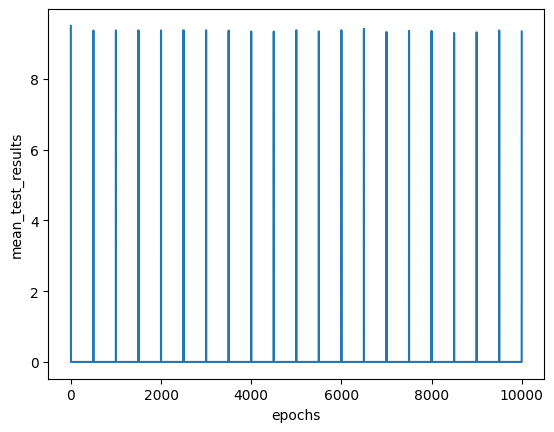

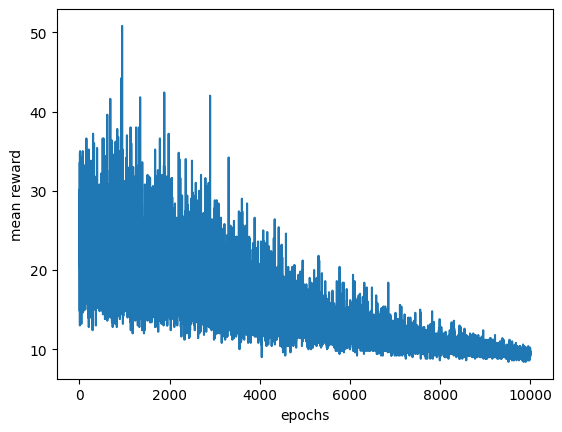

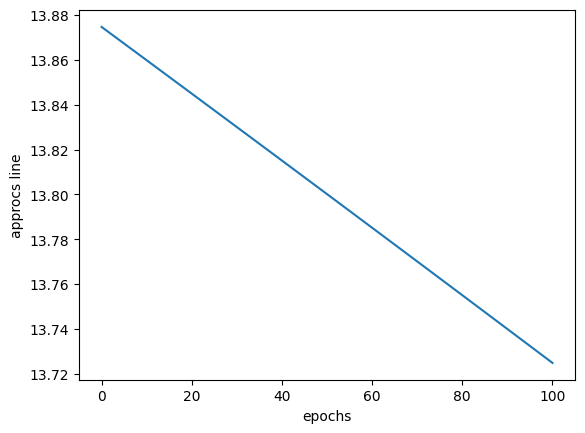

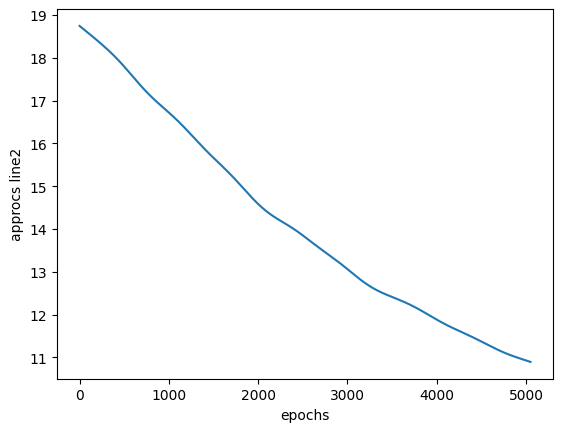

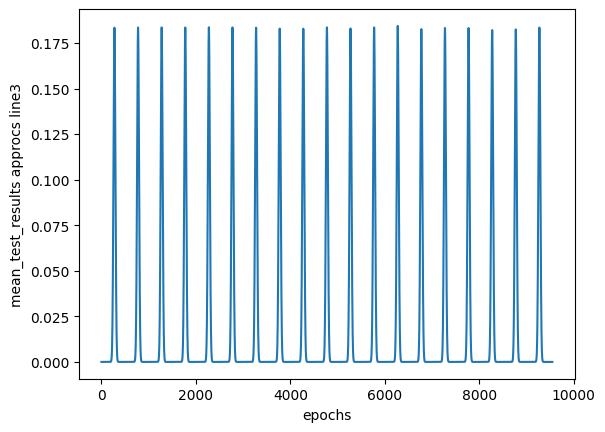

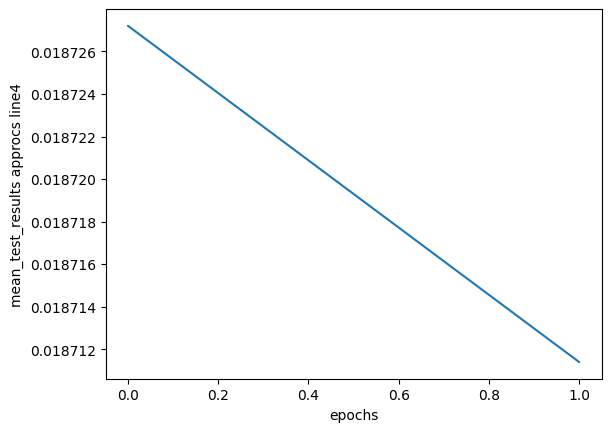

2
Best rewards so far: 38.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 14.0
1  success percent   0.0  mean reward  9.34
Best rewards so far: 18.0
2  success percent   0.0  mean reward  9.48
Best rewards so far: 13.0
3  success percent   0.0  mean reward  9.29
Best rewards so far: 12.0
4  success percent   0.0  mean reward  9.35
Best rewards so far: 16.0
Best rewards so far: 31.0
Best rewards so far: 16.0
Best rewards so far: 55.0
Best rewards so far: 23.0
Best rewards so far: 38.0
Best rewards so far: 36.0
Best rewards so far: 31.0
Best rewards so far: 42.0
Best rewards so far: 79.0
Best rewards so far: 39.0
Best rewards so far: 40.0
Best rewards so far: 70.0
Best rewards so far: 42.0
Best rewards so far: 76.0
Best rewards so far: 45.0
Best rewards so far: 50.0
Best rewards so far: 84.0
Best rewards so far: 51.0
Best rewards so far: 104.0
Best rewards so far: 53.0
Best rewards so far: 107.0
Best rewards so far: 103.0
Best rewards so far: 75.0
Best rewards so far: 

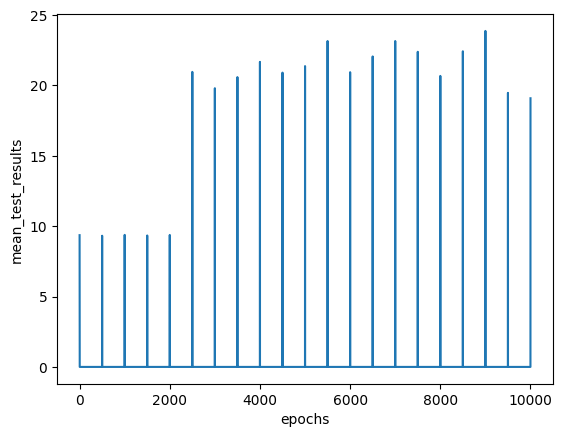

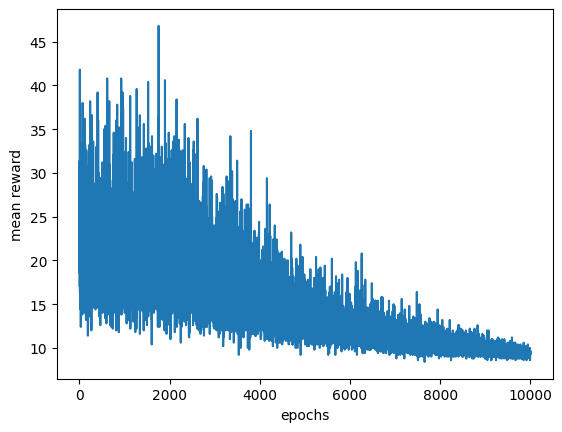

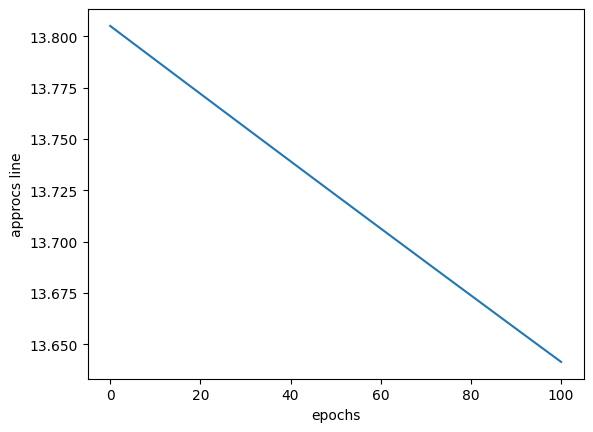

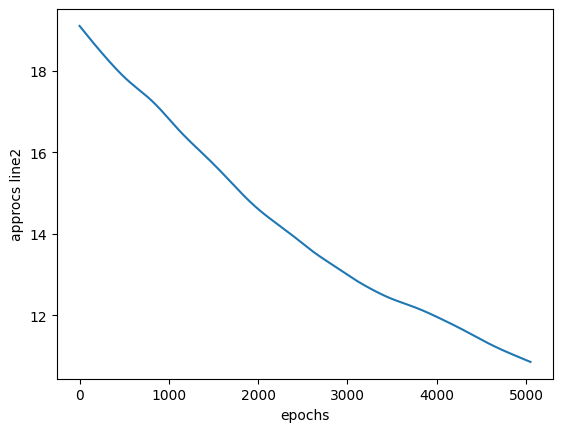

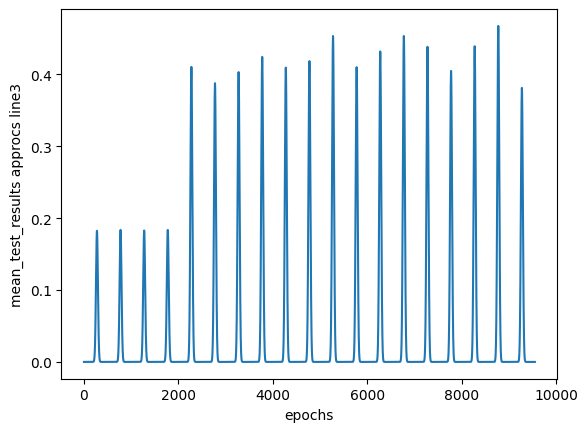

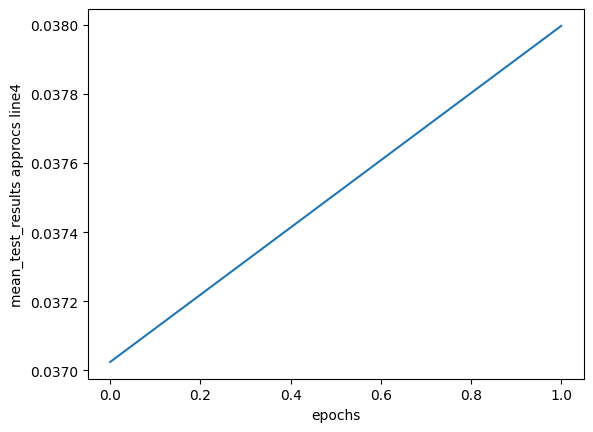

3
Best rewards so far: 30.0
0  success percent   0.0  mean reward  9.25
Best rewards so far: 24.0
1  success percent   0.0  mean reward  18.76
Best rewards so far: 47.0
2  success percent   0.0  mean reward  17.45
Best rewards so far: 16.0
3  success percent   0.0  mean reward  9.26
Best rewards so far: 31.0
4  success percent   0.0  mean reward  9.38
Best rewards so far: 60.0
Best rewards so far: 28.0
Best rewards so far: 107.0
Best rewards so far: 29.0
Best rewards so far: 39.0
Best rewards so far: 41.0
Best rewards so far: 62.0
Best rewards so far: 84.0
Best rewards so far: 71.0
Best rewards so far: 38.0
Best rewards so far: 56.0
Best rewards so far: 90.0
Best rewards so far: 98.0
Best rewards so far: 63.0
Best rewards so far: 65.0
Best rewards so far: 59.0
Best rewards so far: 60.0
Best rewards so far: 62.0
Best rewards so far: 96.0
Best rewards so far: 87.0
0  success percent   0.0  mean reward  9.42
1  success percent   0.0  mean reward  21.64
2  success percent   0.0  mean rewar

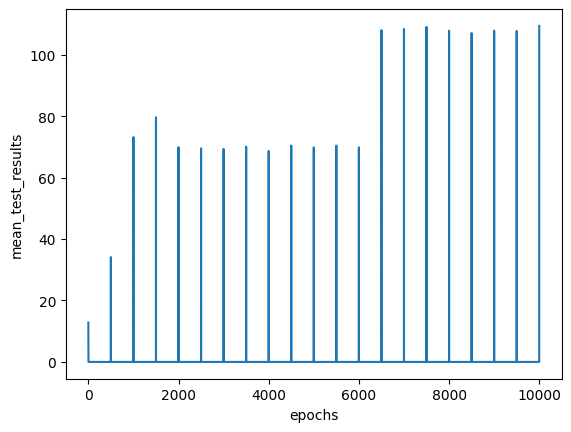

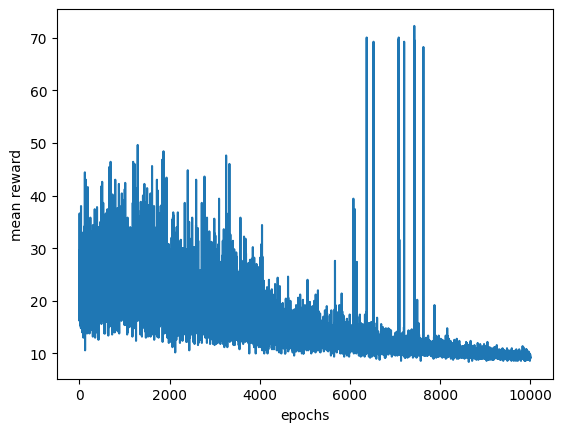

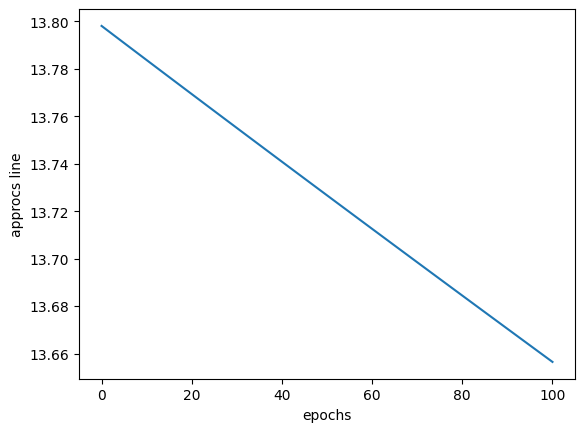

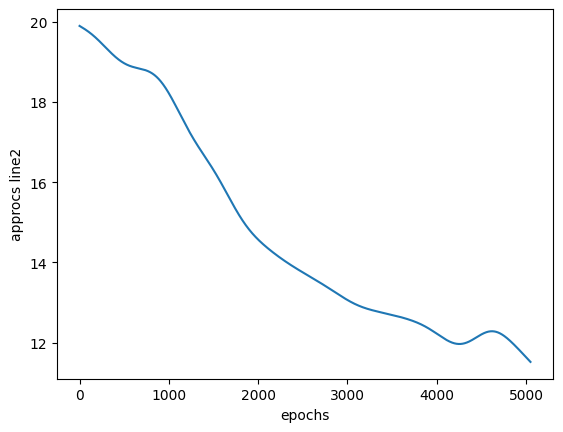

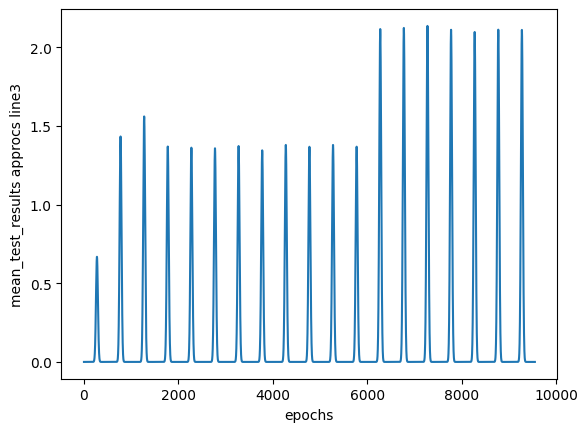

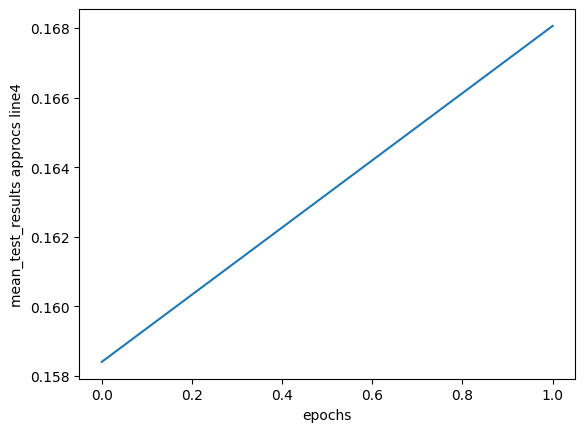

4
Best rewards so far: 10.0
0  success percent   0.0  mean reward  9.3
Best rewards so far: 19.0
1  success percent   0.0  mean reward  9.37
Best rewards so far: 16.0
2  success percent   0.0  mean reward  9.34
Best rewards so far: 31.0
3  success percent   0.0  mean reward  9.4
Best rewards so far: 25.0
4  success percent   0.0  mean reward  9.42
Best rewards so far: 61.0
Best rewards so far: 22.0
Best rewards so far: 28.0
Best rewards so far: 31.0
Best rewards so far: 34.0
Best rewards so far: 17.0
Best rewards so far: 45.0
Best rewards so far: 29.0
Best rewards so far: 36.0
Best rewards so far: 30.0
Best rewards so far: 48.0
Best rewards so far: 37.0
Best rewards so far: 56.0
Best rewards so far: 57.0
Best rewards so far: 52.0
Best rewards so far: 55.0
Best rewards so far: 65.0
Best rewards so far: 58.0
Best rewards so far: 64.0
Best rewards so far: 72.0
Best rewards so far: 67.0
Best rewards so far: 64.0
Best rewards so far: 81.0
Best rewards so far: 111.0
Best rewards so far: 61.0

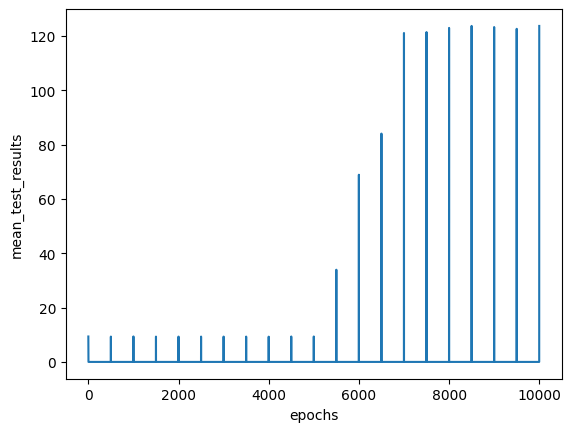

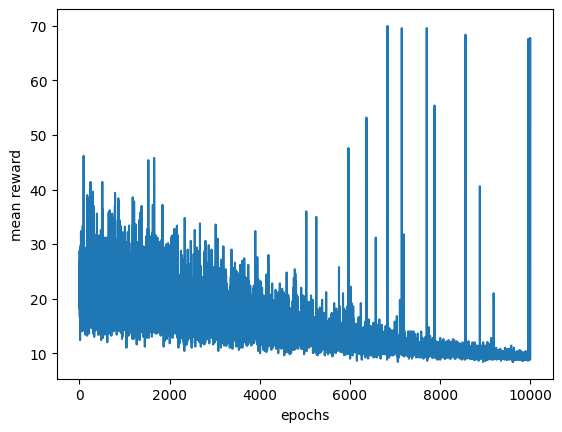

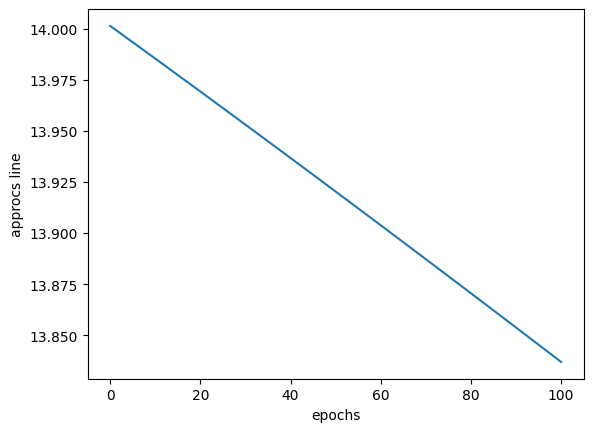

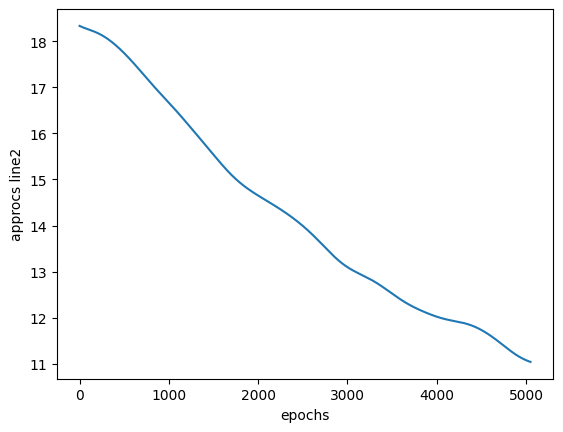

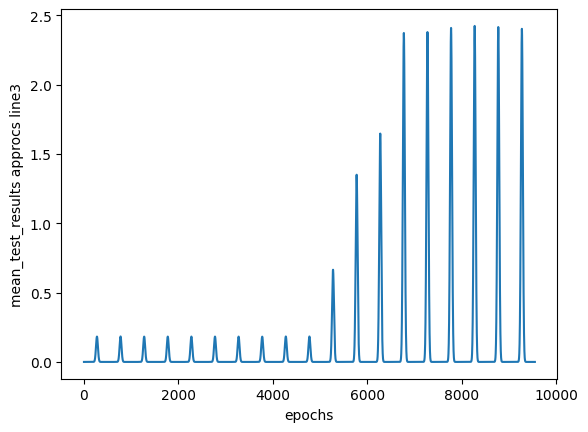

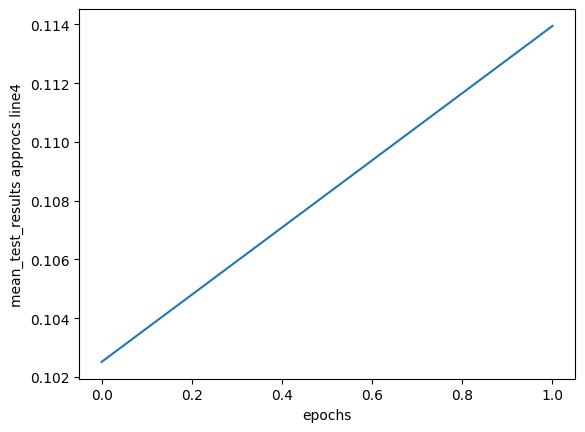

6
Best rewards so far: 20.0
0  success percent   0.0  mean reward  9.35
Best rewards so far: 9.0
1  success percent   0.0  mean reward  9.32
Best rewards so far: 25.0
2  success percent   0.0  mean reward  9.37
Best rewards so far: 29.0
3  success percent   0.0  mean reward  9.29
Best rewards so far: 12.0
4  success percent   0.0  mean reward  9.26
Best rewards so far: 16.0
Best rewards so far: 38.0
Best rewards so far: 13.0
Best rewards so far: 39.0
Best rewards so far: 23.0
Best rewards so far: 55.0
Best rewards so far: 22.0
Best rewards so far: 24.0
Best rewards so far: 33.0
Best rewards so far: 27.0
Best rewards so far: 36.0
Best rewards so far: 34.0
Best rewards so far: 64.0
Best rewards so far: 95.0
Best rewards so far: 37.0
Best rewards so far: 56.0
Best rewards so far: 52.0
Best rewards so far: 53.0
Best rewards so far: 56.0
Best rewards so far: 76.0
Best rewards so far: 57.0
Best rewards so far: 58.0
Best rewards so far: 80.0
Best rewards so far: 84.0
Best rewards so far: 65.0

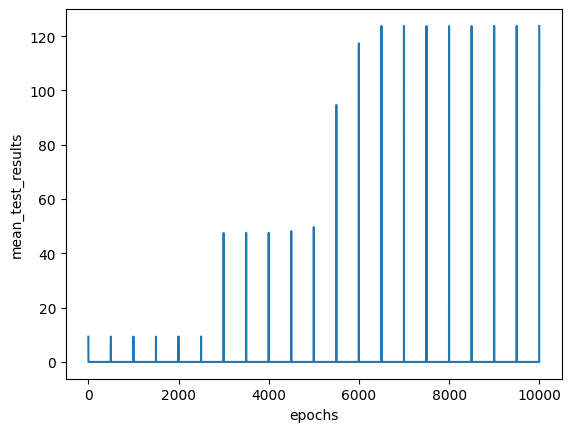

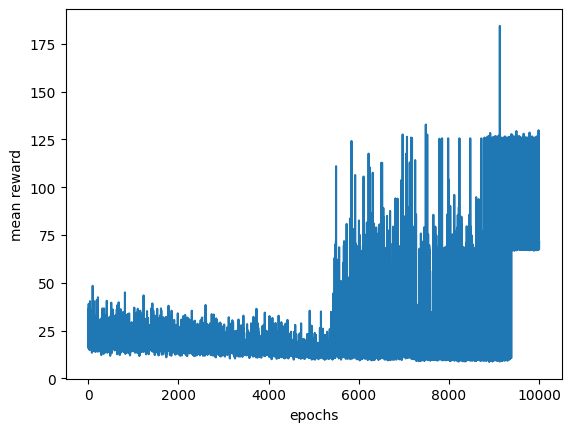

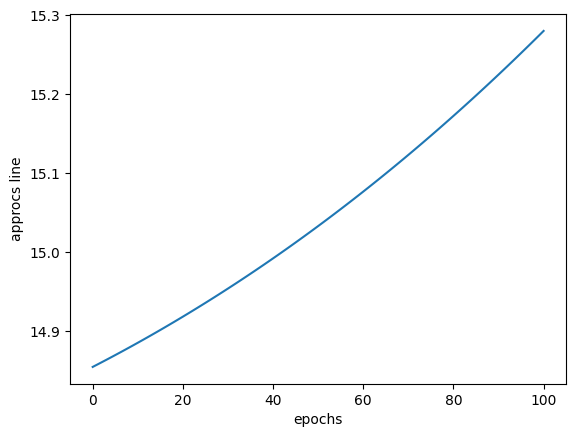

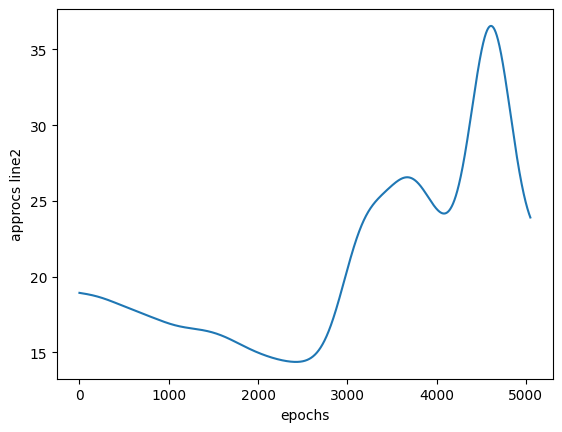

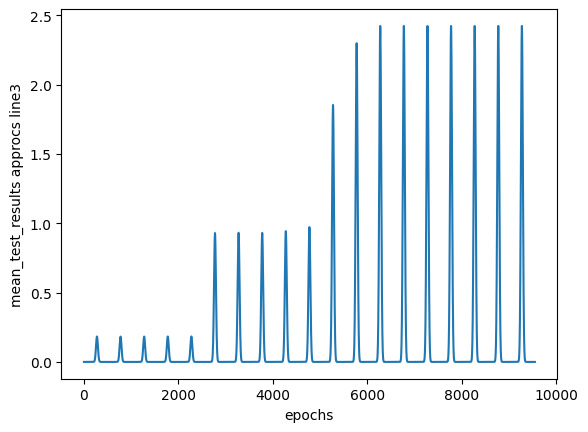

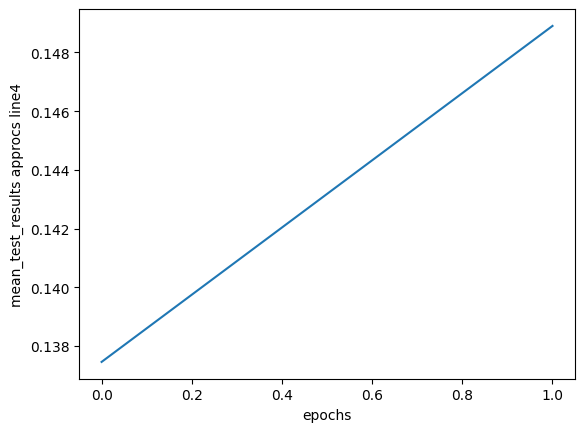

8
Best rewards so far: 20.0
0  success percent   0.0  mean reward  9.36
Best rewards so far: 27.0
1  success percent   0.0  mean reward  9.47
Best rewards so far: 42.0
2  success percent   0.0  mean reward  11.39
Best rewards so far: 23.0
3  success percent   0.0  mean reward  9.27
Best rewards so far: 16.0
4  success percent   0.0  mean reward  9.42
Best rewards so far: 23.0
Best rewards so far: 33.0
Best rewards so far: 31.0
Best rewards so far: 22.0
Best rewards so far: 48.0
Best rewards so far: 32.0
Best rewards so far: 37.0
Best rewards so far: 50.0
Best rewards so far: 57.0
Best rewards so far: 53.0
Best rewards so far: 81.0
Best rewards so far: 65.0
Best rewards so far: 58.0
Best rewards so far: 85.0
Best rewards so far: 52.0
Best rewards so far: 72.0
Best rewards so far: 92.0
Best rewards so far: 96.0
Best rewards so far: 59.0
Best rewards so far: 112.0
Best rewards so far: 86.0
Best rewards so far: 76.0
Best rewards so far: 109.0
0  success percent   0.0  mean reward  9.32
1  

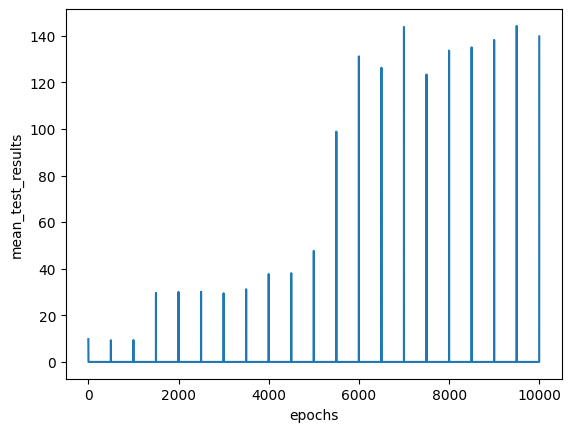

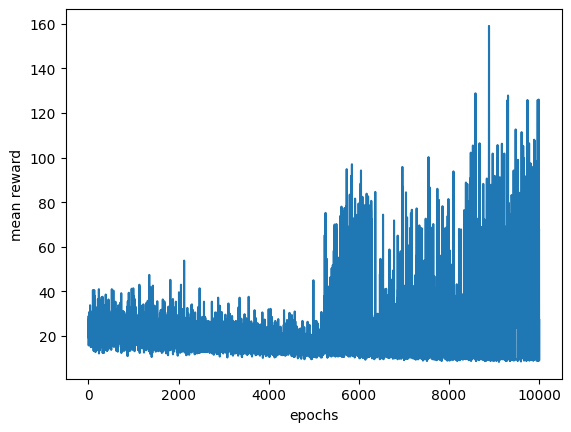

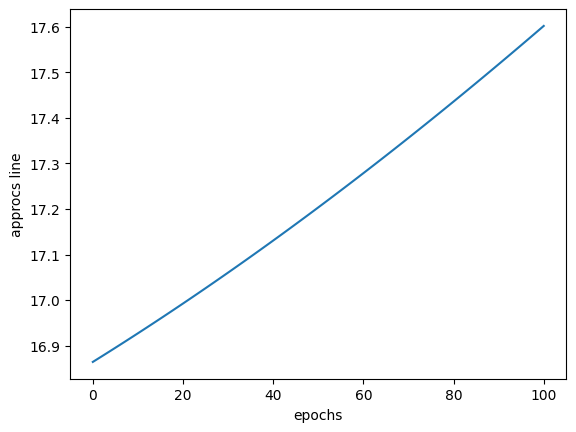

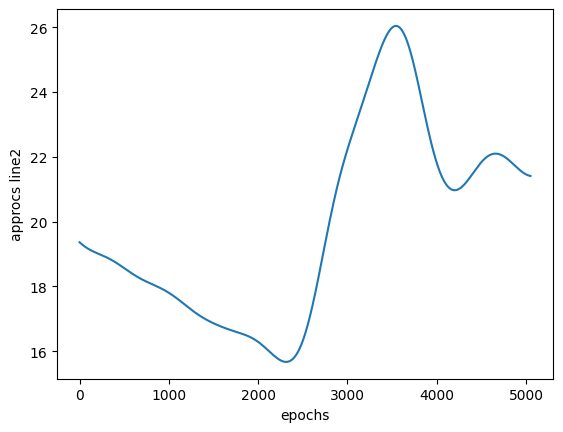

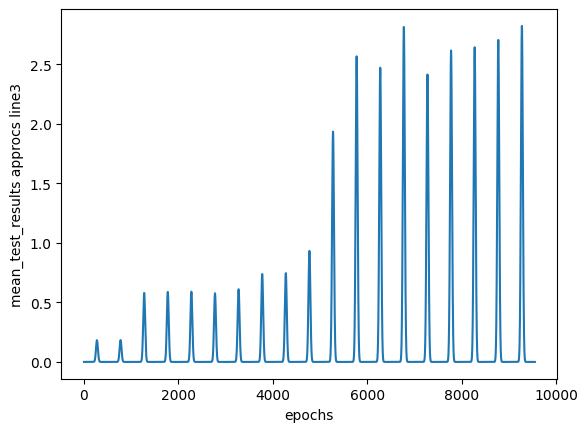

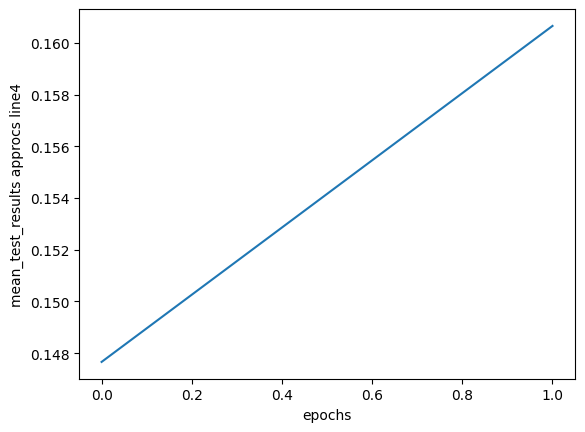

10
Best rewards so far: 50.0
0  success percent   0.0  mean reward  9.37
Best rewards so far: 27.0
1  success percent   0.0  mean reward  9.36
Best rewards so far: 17.0
2  success percent   0.0  mean reward  9.31
Best rewards so far: 23.0
3  success percent   0.0  mean reward  9.39
Best rewards so far: 22.0
4  success percent   0.0  mean reward  9.79
Best rewards so far: 29.0
Best rewards so far: 34.0
Best rewards so far: 44.0
Best rewards so far: 74.0
Best rewards so far: 58.0
Best rewards so far: 60.0
Best rewards so far: 77.0
Best rewards so far: 38.0
Best rewards so far: 62.0
Best rewards so far: 58.0
Best rewards so far: 76.0
Best rewards so far: 85.0
Best rewards so far: 95.0
Best rewards so far: 76.0
Best rewards so far: 62.0
Best rewards so far: 77.0
Best rewards so far: 79.0
Best rewards so far: 92.0
Best rewards so far: 148.0
0  success percent   0.0  mean reward  9.33
1  success percent   0.0  mean reward  9.35
2  success percent   0.0  mean reward  9.34
3  success percent  

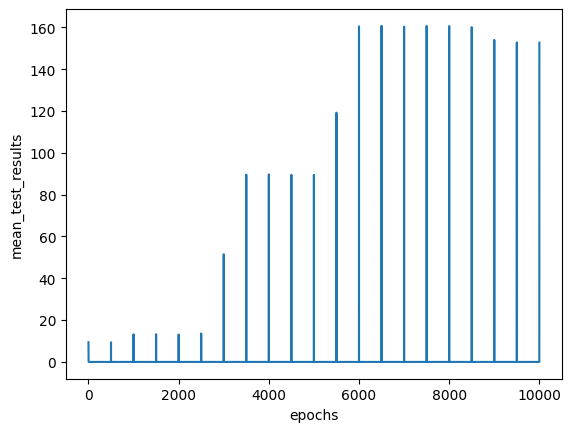

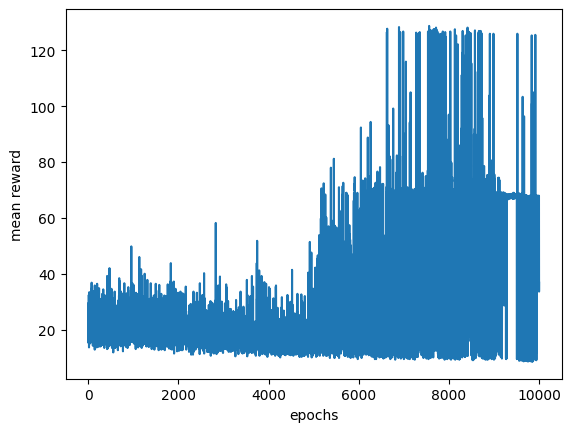

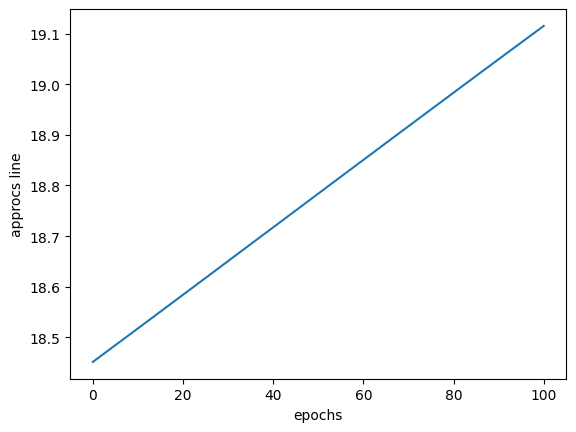

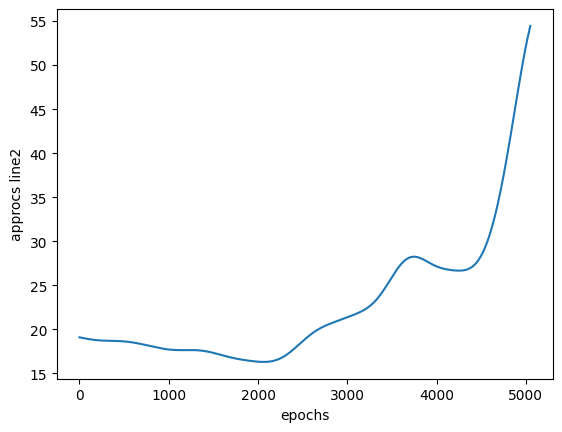

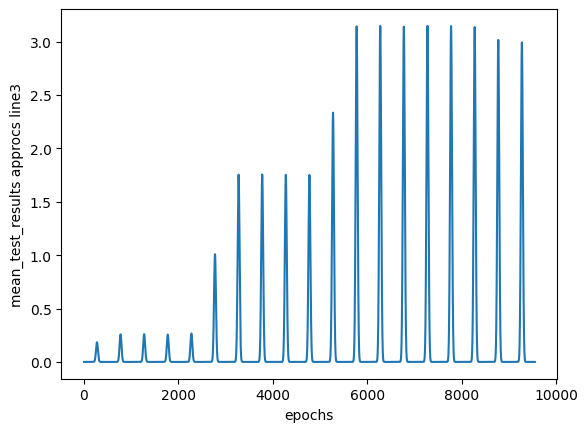

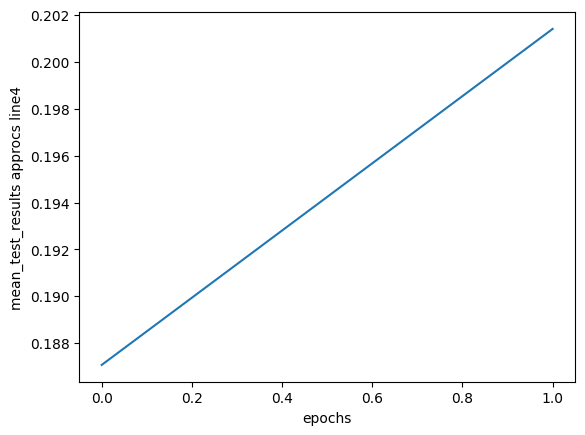

12
Best rewards so far: 63.0
0  success percent   0.0  mean reward  17.91
Best rewards so far: 12.0
1  success percent   0.0  mean reward  9.34
Best rewards so far: 13.0
2  success percent   0.0  mean reward  9.28
Best rewards so far: 27.0
3  success percent   0.0  mean reward  9.38
Best rewards so far: 15.0
4  success percent   0.0  mean reward  9.23
Best rewards so far: 21.0
Best rewards so far: 23.0
Best rewards so far: 29.0
Best rewards so far: 33.0
Best rewards so far: 46.0
Best rewards so far: 31.0
Best rewards so far: 75.0
Best rewards so far: 59.0
Best rewards so far: 61.0
Best rewards so far: 64.0
Best rewards so far: 44.0
Best rewards so far: 46.0
Best rewards so far: 84.0
Best rewards so far: 59.0
Best rewards so far: 65.0
Best rewards so far: 71.0
Best rewards so far: 78.0
Best rewards so far: 69.0
Best rewards so far: 62.0
Best rewards so far: 91.0
Best rewards so far: 64.0
Best rewards so far: 106.0
Best rewards so far: 67.0
Best rewards so far: 130.0
Best rewards so far:

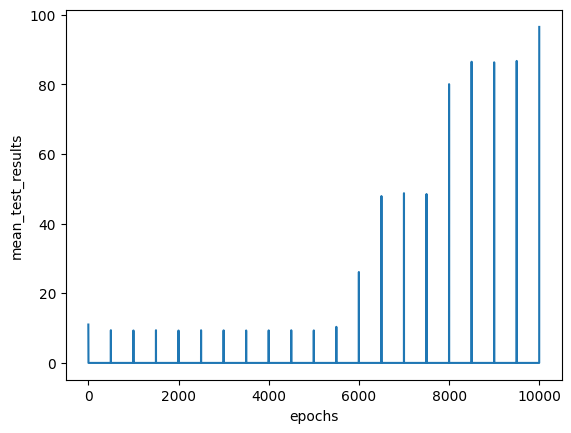

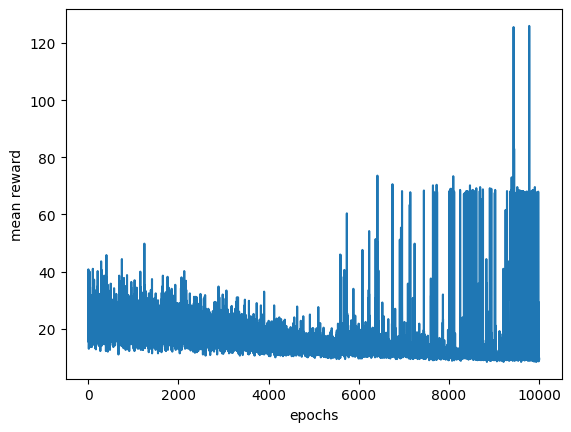

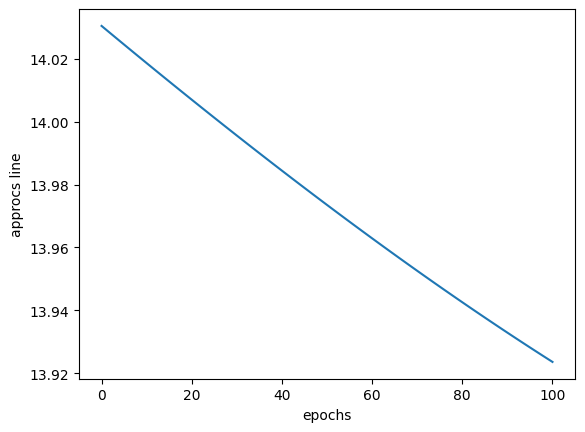

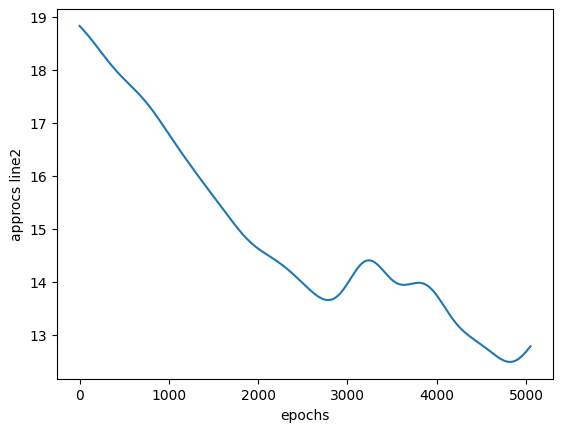

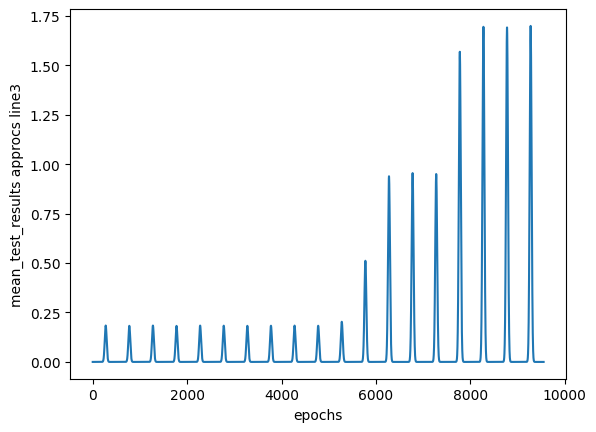

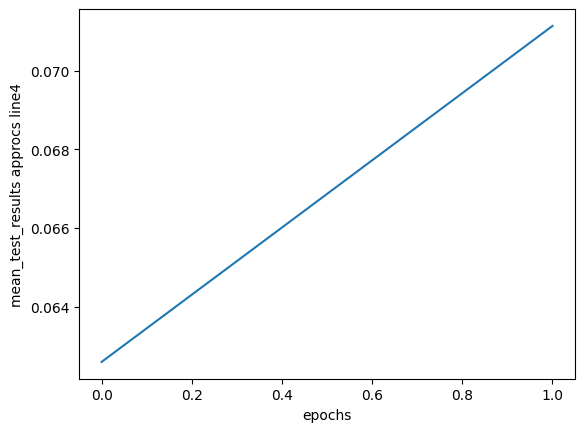

16
Best rewards so far: 14.0
0  success percent   0.0  mean reward  9.18
Best rewards so far: 29.0
1  success percent   0.0  mean reward  9.23
Best rewards so far: 16.0
2  success percent   32.0  mean reward  172.27
Best rewards so far: 17.0
3  success percent   0.0  mean reward  9.28
Best rewards so far: 25.0
4  success percent   0.0  mean reward  9.38
Best rewards so far: 20.0
Best rewards so far: 26.0
Best rewards so far: 19.0
Best rewards so far: 37.0
Best rewards so far: 63.0
Best rewards so far: 37.0
Best rewards so far: 37.0
Best rewards so far: 21.0
Best rewards so far: 32.0
Best rewards so far: 56.0
Best rewards so far: 34.0
Best rewards so far: 63.0
Best rewards so far: 44.0
Best rewards so far: 62.0
Best rewards so far: 52.0
Best rewards so far: 75.0
Best rewards so far: 69.0
Best rewards so far: 49.0
Best rewards so far: 56.0
Best rewards so far: 58.0
Best rewards so far: 59.0
Best rewards so far: 72.0
Best rewards so far: 78.0
Best rewards so far: 72.0
Best rewards so far:

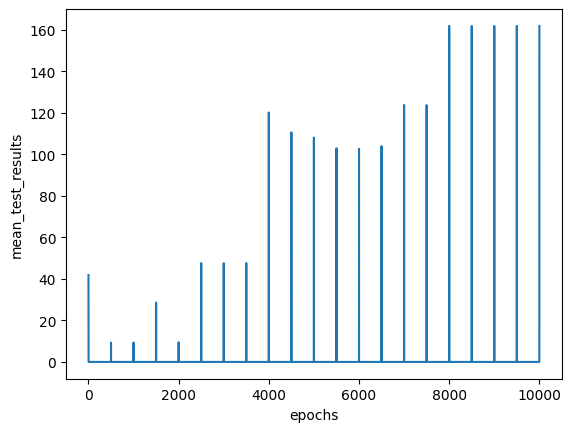

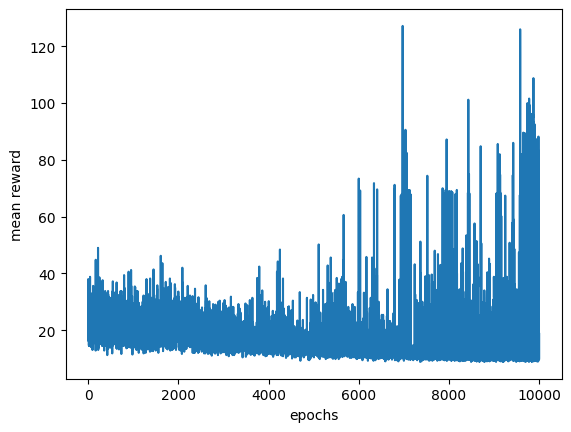

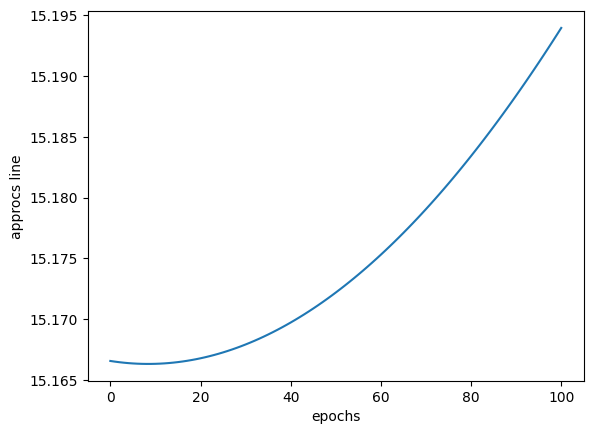

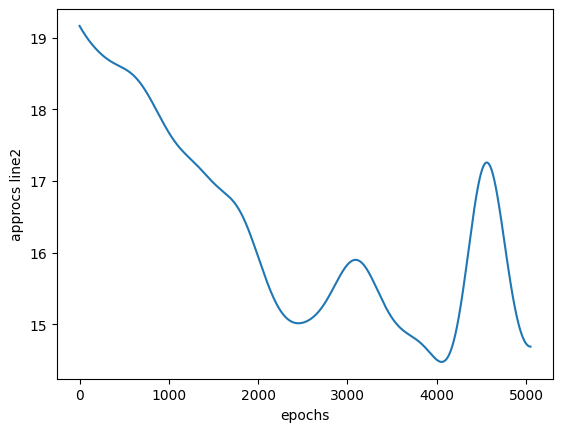

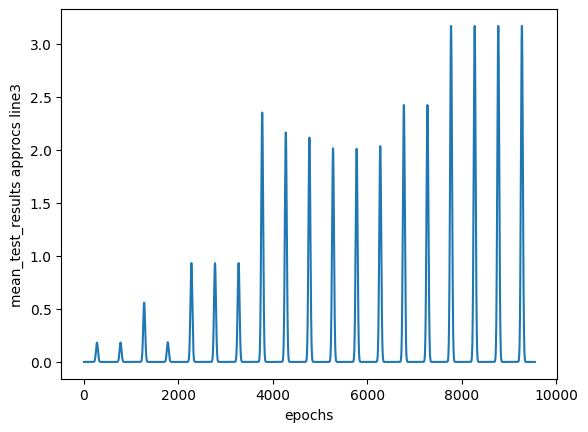

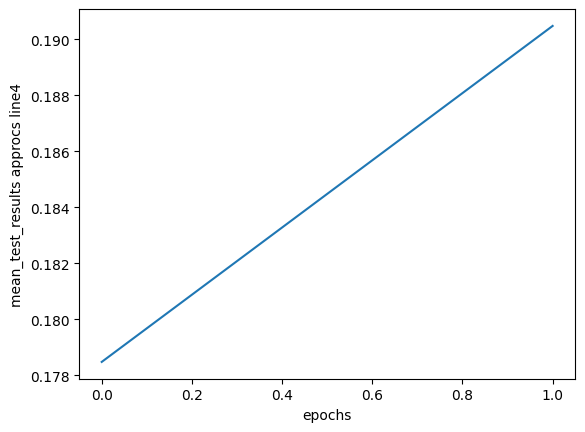

In [400]:
learning_rate_a = 0.2
game_name = "CartPole-v0"
env = gym.make(game_name)
in_states = env.observation_space.shape[0]
out_actions = env.action_space.n
env.close()
a_types = [ '', 'ReLU', 'ReLU', 'Linear']

num_of_nn = 5


topology_lists = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
        
episodes = 10000

total_time_start = time.time()

for t in topology_lists:
    this_time_start = time.time()
    print(t, this_time_start)
    
    h1_nodes = t
    h2_nodes = t
 
    dqn_s = []
  
    ct = datetime.datetime.now()
    ct = str(ct)
    ct = ct.replace(":", "-")
    ct = ct.replace(" ", "_")
    ct = ct[:-7]
    ct = ct + '_' + str(t)

    # preset models
    
    for i in range(num_of_nn):
        #print(i)
        layers_net = [input_layer(in_states), 
        layer(lr = learning_rate_a, prev_size = in_states, my_size=h1_nodes, activation_type=a_types[1]), 
        layer(lr = learning_rate_a, prev_size = h1_nodes, my_size=h2_nodes, activation_type=a_types[2]), 
        layer(lr = learning_rate_a, prev_size = h2_nodes, my_size=out_actions, activation_type=a_types[3])]
        
        topology = [in_states, h1_nodes, h2_nodes,  out_actions]
        
        policy_dqn = plastic_nn(optimizer="Adam")
        policy_dqn.append_layers(layers_net)
        
        dqn_test = DQN(ct = ct, game_name = game_name, mini_batch_size = 64, num_divisions = 1)
        dqn_test.set_tag(str(i))
        dqn_test.save_info(f'lr: {learning_rate_a} \n{topology} \na:{a_types}\n')
        
        dqn_s.append(dqn_test)
        dqn_s[i].init_train_data(policy_dqn, episodes)


    
    summs = np.zeros(shape = episodes+1)
    tests = np.zeros(shape = (episodes+1))
    # одномвременно
    for e in range(episodes + 1):
        for i in range (num_of_nn):  
            summs[e] += dqn_s[i].run_one_epoch(e)
            if (e % 500 == 0):
                test_dqn = plastic_nn(optimizer="Adam")
                test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
                succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
                print(i,' success percent  ', succ_perc, ' mean reward ', mean_reward)
                tests[e] += mean_reward
    
    
    # последовательно
    # for i in range (num_of_nn):
    #     for e in range(episodes + 1):
    #         summs[e] += dqn_s[i].run_one_epoch(e)
            

    
    for i in range (num_of_nn):
        #print(i)
        test_dqn = plastic_nn(optimizer="Adam")
        test_dqn.load(f'{dqn_s[i].path}/mc_policy_best')
        succ_perc, mean_reward, reward_list = dqn_s[i].test(test_dqn, episodes = 100)
        print('final: success percent  ', succ_perc, ' mean reward ', mean_reward)
        dqn_s[i].post_train()
    

    this_time_end = time.time()
    this_time_diff = this_time_end - this_time_start
    print(this_time_diff)
    
   
   
    mean_results = np.asarray(summs) / num_of_nn
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('mean reward')
    plt.plot(mean_results)  
    plt.savefig(f'{dqn_s[0].ct}/mean_values.png')
    plt.show()
    plt.close()

   
    approc_line = copy.deepcopy(mean_results)  
    for i in range(100):
        approc_line = moving_average(approc_line, 100)

    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('approcs line')
    plt.plot(approc_line)
    plt.savefig(f'{dqn_s[0].ct}/approc.png')
    plt.show()
    plt.close()



    # approc_line2 = copy.deepcopy(mean_results)  
    # for i in range(50):
    #     approc_line2 = moving_average(approc_line2, 100)
        
    # plt.figure()
    # plt.xlabel('epochs')
    # plt.ylabel('approcs line2')
    # plt.plot(approc_line2)
    # plt.savefig(f'{dqn_s[0].ct}/mean_test_results1.png')
    # plt.show()
    # plt.close()


    
    # approc_line3 = copy.deepcopy(mean_test_results)  
    
    # for i in range(50):
    #     approc_line3 = moving_average(approc_line3, 10)
    # plt.figure()
    # #plt.subplot(2,1,2)
    # plt.xlabel('epochs')
    # plt.ylabel('mean_test_results approcs line3')
    # plt.plot(approc_line3)
    # plt.savefig(f'{dqn_s[0].ct}/mean_test_results2.png')
    # plt.show()
    # plt.close()


    mean_test_results = np.asarray(tests) / num_of_nn
    
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('mean_test_results')
    plt.plot(mean_test_results)    
    plt.savefig(f'{dqn_s[0].ct}/mean_test_results.png')
    plt.show()
    plt.close()


    
    approc_line4 = copy.deepcopy(mean_test_results)  
    approc_line4 = moving_average(approc_line4, episodes)
    
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('mean_test_results approcs line4')
    plt.plot(approc_line4)
    plt.savefig(f'{dqn_s[0].ct}/mean_test_results_approc_line.png')
    plt.show()
    plt.close()



total_time_end = time.time()

total_time_diff = total_time_end - total_time_start
print(total_time_diff)

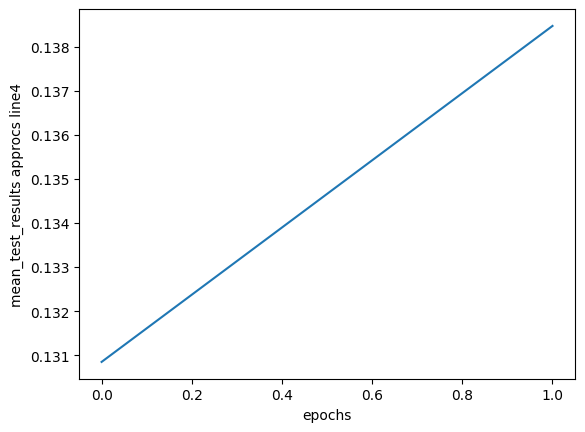

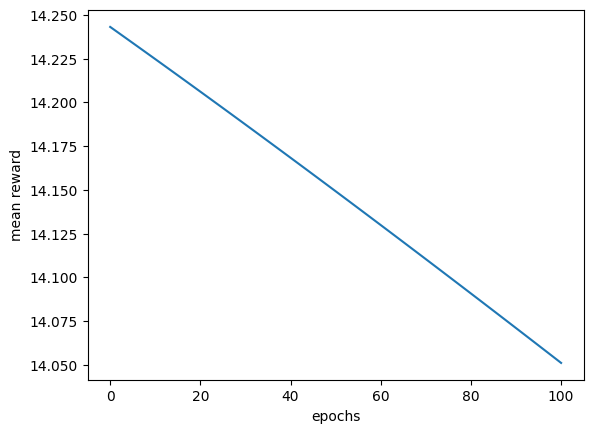

In [366]:
import copy
cpy_arr = copy.deepcopy(mean_results)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
for i in range(100):
    cpy_arr = moving_average(cpy_arr, 100)


plt.figure()

plt.xlabel('epochs')
plt.ylabel('mean reward')
plt.plot(cpy_arr)

plt.show()
plt.close()

In [232]:
data_save = copy.deepcopy(mean_results)

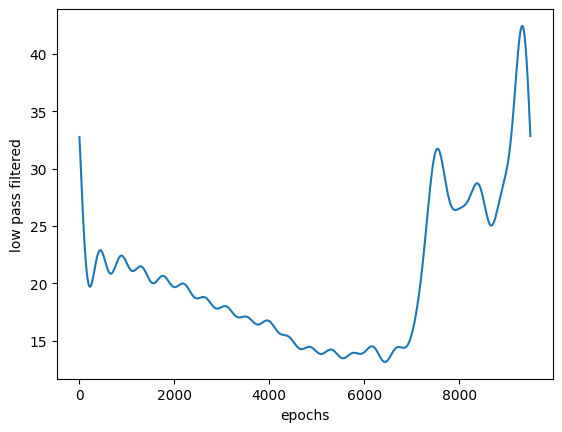

In [349]:
def low_pass_filter(adata: np.ndarray, bandlimit: int = 1000, sampling_rate: int = 44100) -> np.ndarray:
    # translate bandlimit from Hz to dataindex according to sampling rate and data size
    bandlimit_index = int(bandlimit * adata.size / sampling_rate)

    fsig = np.fft.fft(adata)
    
    for i in range(bandlimit_index + 1, len(fsig) - bandlimit_index ):
        fsig[i] = 0
        
    adata_filtered = np.fft.ifft(fsig)

    return np.real(adata_filtered)

cpy_arr_12_12__ = copy.deepcopy(cpy_arr_12_12)
for i in range(1):
    cpy_arr_12_12__ = low_pass_filter(cpy_arr_12_12__, bandlimit = 1000, sampling_rate = 441000)
plt.figure()

plt.xlabel('epochs')
plt.ylabel('low pass filtered')
plt.plot(cpy_arr_12_12__)

plt.show()
plt.close()

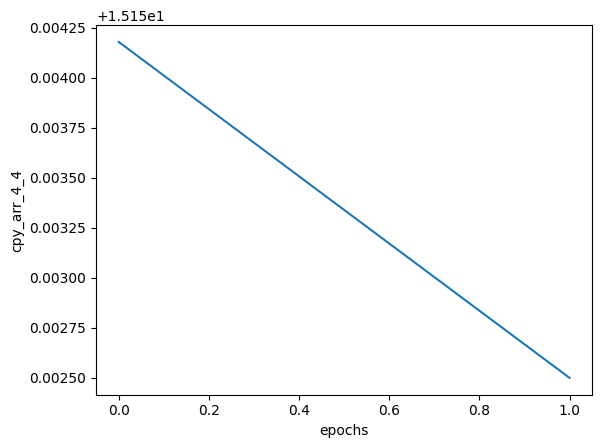

In [357]:
cpy_arr_4_4 = copy.deepcopy(mean_results)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid')  / w

cpy_arr_4_4 = moving_average(cpy_arr_4_4, 10000) 

# for i in range(300):
#     cpy_arr_12_12 = moving_average(cpy_arr_12_12, 25)
#     if (i % 5 == 0):
#         plt.figure(i)
        
#         plt.xlabel('epochs')
#         plt.ylabel('1')
#         plt.plot(cpy_arr_12_12)
        
#         plt.show()
#         plt.close()
# nummm = 10

# cut = cpy_arr_12_12[1000:4000]
# for i in range(50):
#      cut = moving_average(cut, 10)
    
#      if (i % 5 == 0):
plt.figure(i)

plt.xlabel('epochs')
plt.ylabel('cpy_arr_4_4')
plt.plot(cpy_arr_4_4)

plt.show()
plt.close()

In [155]:
def is_increasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

def is_descreasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))

def monotonic(L):
    return non_decreasing(L) or non_increasing(L)

is_descreasing(cpy_arr2)

True